# Assignment 3 - Policy Gradient Methods

This notebook walks you through the essentials of Reinforcement Learning (RL) implementation. We hope after this you can comfortably train RL algorithms on your own environments and easily extend to more complex variations (e.g. TRPO, PPO).

In this notebook you will learn how to:
- Use open source reinforcement learning RL environments
- Set up the training pipelines for RL
- Testing different environments and reward engineering
- Implementing Policy Gradient method REINFORCE and its variation with a baseline function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## 1. Set up the environment

For this assignment we will work with the gym-minigrid package, an efficient implementation of a 2D gridworld environment that will allow you to quickly train policies and verify your implementation of Policy Gradients.

You can find the package documentation here: https://github.com/maximecb/gym-minigrid (Please install the package following the installation instructions using pip)

When starting a Deep RL project it is always a good idea to rely on widely used environment implementations, as those will be well tested and results on them are easily reproducible by others. In this first part of the assignment you will learn how to set-up an opensource environment and integrate it into your project.

If it is not automatically installed through requirements.txt file, you can follow the installation instructions from the Github repo of gym-minigrid. To verify that your installation worked we included the script `test_env_manual.py` that lets you play test environments with your keyboard (use only UP, LEFT and RIGHT keys). Please continue after you verified that you are able to complete one level with keyboard inputs.

### Rendering images from the environment (3 pts)

To debug the progress of our RL loop we will need to render the state of the environment.
Here we show how to load an instance of the environment type `MiniGrid-Empty-5x5-v0`, reset it, selecting an action, taking an action step in the environment, and finally rendering the current state.


Follow this carefully for your Todo task in the next block.

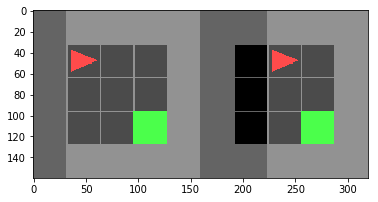

In [2]:
import gym
import gym_minigrid
import matplotlib.pyplot as plt

env = gym.make('MiniGrid-Empty-5x5-v0')
env.reset()
before_img = env.render('rgb_array')
action = env.actions.forward
obs, reward, done, info = env.step(action)
after_img = env.render('rgb_array')

plt.imshow(np.concatenate([before_img, after_img], 1))

### Play with your environment (2 pts)

Following the above code, Create an instance of the environment type `MiniGrid-Empty-8x8-v0`, reset, take an action step *right* and get the outputs of the environment's `step()` function. Finally, render the new state of the environment to visualize it.

Observation: {'image': array([[[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]]], dtype=uint8), 'direction': 1, 'm

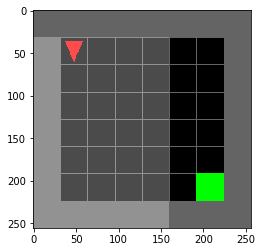

In [3]:
################# TODO: YOUR CODE BELOW #############################
#################  Each todo here is 1 line of code  ################

# 1. Make a new environment MiniGrid-Empty-8x8-v0
env = gym.make('MiniGrid-Empty-8x8-v0')

# 2. Reset the environment
env.reset()

# 3. Select the action right
action = env.actions.right

# 4. Take a step in the environment and store it in appropriate variables
obs, reward, done, info = env.step(action)

# 5. Render the current state of the environment
img = env.render('rgb_array')
################# YOUR CODE ENDS HERE ###############################

print('Observation:', obs)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.imshow(img)
plt.show()

## Modifying an existing environment (2 pts)

As you can see the environment's observation output also contains a rendered image as state representation (`obs['image']`). However, for this assignment we want to train out deep RL agent from **non-image state** input (for faster convergence).

We will create a slightly altered version of the [FullyObsWrapper](https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/wrappers.py#L223) from the repository who's observation function returns a flat vector representing the full grid.

TODO: Please complete the wrapper class below and verify that a wrapped environment returns a flat vector observation of the correct shape.

Observation: [10  0  1  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0  1  0  0
  1  0  0  1  0  0  1  0  0  8  1  0] , Observation Shape:  (108,)
Reward: 0
Done: False
Info: {}
Image shape: (256, 256, 3)


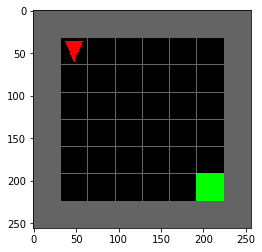

In [4]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

max_env_steps = 50

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        ############################### TODO: YOUR CODE BELOW ##############################
        ### Your code should return a flattened version of the grid.                     ###
        ####################################################################################
        flattened_grid = full_grid.reshape(-1)
        ################################# END OF YOUR CODE #################################
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)


################# YOUR CODE BELOW ###################################
env = gym.make('MiniGrid-Empty-8x8-v0')
env = FlatObsWrapper(env)
action = env.actions.right
obs, reward, done, info = env.step(action)
img = env.render('rgb_array')

################# YOUR CODE ENDS HERE ###############################

print('Observation:', obs, ', Observation Shape: ', obs.shape)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)
print('Image shape:', img.shape)
plt.close()
plt.imshow(img)
plt.show()

### Plotting Videos

As final step in the environment setup we provide a helper function to log videos of policy rollouts in the environment (see utils.py). Please check whether you can render the rollout of a random policy in the cell below.

In [5]:
from gym.wrappers import Monitor
from utils import show_video

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))


# Random agent - we only use it in this cell for demonstration
class RandPolicy:
    def __init__(self, action_space):
        self.action_space = action_space
        
    def act(self, *unused_args):
        return self.action_space.sample(), None

# This function plots videos of rollouts (episodes) of a given policy and environment
def log_policy_rollout(policy, env_name, pytorch_policy=False):
    # Create environment with flat observation
    env = gen_wrapped_env(env_name)

    # Initialize environment
    observation = env.reset()

    done = False
    episode_reward = 0
    episode_length = 0

    # Run until done == True
    while not done:
      # Take a step
        if pytorch_policy: 
            observation = torch.tensor(observation, dtype=torch.float32)
            action = policy.act(observation)[0].data.cpu().numpy()
        else:
            action = policy.act(observation)[0]
        observation, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

    print('Total reward:', episode_reward)
    print('Total length:', episode_length)

    env.close()
    
    show_video()

# Test that the logging function is working
test_env_name = 'MiniGrid-Empty-8x8-v0'
rand_policy = RandPolicy(FlatObsWrapper(gym.make(test_env_name)).action_space)
log_policy_rollout(rand_policy, test_env_name)

Total reward: 0
Total length: 50


## 2. Constructing the Rollout Buffer

Now that we can create an environment instance we can start implementing the components of the policy training framework. On a very high level, the policy gradient training loop looks like this:

1. Collect rollouts of the current policy, store all trajectories.
2. Compute policy gradient using stored rollouts. Update the policy.
3. Repeat.

First, we will look into the class that stores all rollouts collected with the current policy. For this assignment we provide the class `RolloutStorage` that implements a simple storage structure for storing the information of arbitrarily many policy rollouts.

Please look at the cell below and familiarize yourself with the interface the class provides. In particular focus on the functions:

- `insert(...)`: adds a new trajectory step to the rollout storage
- `compute_returns(...)`: computes the future discounted returns for all rollout time steps after rollout collection is completed
- `batch_sampler(...)`: returns an iterator over rollout batches, which we will use for the policy gradient update

You can ignore the function `estimate_returns(...)` for now, we will make use of it later.

In [6]:
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

class RolloutStorage():
    def __init__(self, rollout_size, obs_size):
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()
        
    def insert(self, step, done, action, log_prob, reward, obs):    
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)
        
    def reset(self):
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size+1, 1, requires_grad=False)
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)  # Assuming Discrete Action Space
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)
        
    def compute_returns(self, gamma):
        self.last_done = (self.done == 1).nonzero().max()  # Compute Returns until the last finished episode
        self.returns[self.last_done+1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done+1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]
        
    def batch_sampler(self, batch_size, get_old_log_probs=False):
        sampler = BatchSampler(
            SubsetRandomSampler(range(self.last_done)),
            batch_size,
            drop_last=True)
        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

## 3. Constructing the Policy Network (9 pts)

Now that we can store rollouts we need a policy to collect them. In the following you will complete the provided base code for the policy class. The policy is instantiated as a small neural network with simple fully-connected layers, the `ActorNetwork`. 

Start your implementation by constructing the network in `ActorNetwork`'s constructor using the `pytorch` modules `nn.Sequential` and `nn.Linear`. 

After the network is constructed we can complete the `Policy` class that uses the actor to implement the `act(...)` and `update(...)` functions. Please follow the instructions in the TODO blocks for completing the implementations. The gradient function for the policy update takes the following form:

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] $$

Here, $\theta$ are the parameters of the policy network $\pi_{\theta}$ and $V_t(s)$ is the observed future discounted reward from state $s$ onwards which should be **maximized**.

**Entropy Loss:** In order to encourage exploration, it is a common practice to add a weighted entropy-loss component that maximizes the entropy ($\mathcal{H}$) of the policy distribution, so it takes diverse actions. So the joint objective becomes:

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] + \nabla_{\theta}\mathcal{H}\big[\pi_\theta(a, s)\big]$$

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from utils import count_model_params

class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions
        
        ############################## TODO: YOUR CODE BELOW ###############################
        ### 1. Build the Actor network as a torch.nn.Sequential module                   ###
        ###    with the following layers:                                                ###
        ###        (1) a Linear layer mapping from input dimension to hidden dimension   ###
        ###        (2) a Tanh non-linearity                                              ###
        ###        (3) a Linear layer mapping from hidden dimension to hidden dimension  ###
        ###        (4) a Tanh non-linearity                                              ###
        ###        (5) a Linear layer mapping from hidden dimension to number of actions ###
        ### HINT: We do not need an activation on the output, because the actor is       ###
        ###       predicting logits, not action probabilities.                           ###
        ####################################################################################
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_actions),
            nn.Softmax(dim=-1)
        )
        ################################# END OF YOUR CODE #################################
        
    def forward(self, state):
        x = self.fc(state)
        return x

class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate,
                 batch_size, policy_epochs, entropy_coef=0.001):
        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        ############################## TODO: YOUR CODE BELOW ###############################
        ### 1. Run the actor network on the current state to retrieve the action logits  ###
        ### 2. Build a Categorical(...) instance from the logits                         ###
        ### 3. Sample an action from the Categorical using the build-in sample() function###
        ####################################################################################
        logits = self.actor(state)
        dist = Categorical(logits)
        action = dist.sample()
        ################################# END OF YOUR CODE #################################
        log_prob = dist.log_prob(action)
        return action, log_prob
    
    def evaluate_actions(self, state, action):
        ############################## TODO: YOUR CODE BELOW ###############################
        ### This function is used for policy update to evaluate log_prob and entropy of  ###
        ### actor network.                                                               ###
        ### TODO: Compute logits and distribution just like above                        ###
        ####################################################################################
        logits = self.actor(state)
        dist = Categorical(logits)
        ################################# END OF YOUR CODE #################################
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy
    
    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
    
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
    
                ############################## TODO: YOUR CODE BELOW ###############################
                ### 4. Compute the mean loss for the policy update using action log-             ###
                ###     probabilities and policy returns                                         ###
                ### 5. Compute the mean entropy for the policy update                            ###
                ###    *HINT*: PyTorch optimizer is used to minimize by default.                 ###
                ###     The trick to maximize a quantity is to negate its corresponding loss.    ###
                ####################################################################################
                policy_loss = -torch.mean(torch.mul(log_probs_batch, returns_batch), 0)
                entropy_loss = -torch.mean(entropy_batch, 0)
                ################################# END OF YOUR CODE #################################
                
                loss = policy_loss + self.entropy_coef * entropy_loss
                #loss = policy_loss
                
                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()
                
    @property
    def num_params(self):
        return count_model_params(self.actor)

## 4. Setting up the Training Loop (6 pts)

Now that all classes are implemented we can combine them in the training loop and check whether everything is working!

We provide a scaffolding for the `train(...)` function below. It contains some code for logging of results and has TODO blocks where you should implement the key components of the training loop. Please go through the blocks one-by-one and complete the implementation.

We will use this `train(...)` function for all experiments below. You can test it in the following code blocks.

**Note about setting seeds**: RL training is notoriously unstable. Especially in the beginning of training random chance can have a large influence on the training progress, which is why RL researchers always need to report results averaged across multiple random seeds. We therefore fix the random seed at the beginning of training. However, if you observe that your algorithm is not training it can be beneficial to try another run with a different random seed to check whether the last run was just "unlucky".

In [71]:
from IPython.display import clear_output
from utils import AverageMeter, plot_learning_curve
import time

def train(env, rollouts, policy, params, seed=123):
    # SETTING SEED: it is good practice to set seeds when running experiments to keep results comparable
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.seed(seed)

    rollout_time, update_time = AverageMeter(), AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(params.num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = AverageMeter(), AverageMeter()
        done = False
        prev_obs = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()
        
        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done:
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info: 
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                obs = env.reset()
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs

            ############################## TODO: YOUR CODE BELOW ###############################
            ### 1. Call the policy to get the action for the current observation,            ###
            ### 2. Take one step in the environment (using the policy's action)              ###
            ####################################################################################
            #print('obs', obs)
            action, log_prob = policy.act(obs)
            #print('action', action, log_prob)
            obs, reward, done, info = env.step(action)
            ################################# END OF YOUR CODE #################################

            
            ############################## TODO: YOUR CODE BELOW ###############################
            ### 3. Insert the sample <done, action, log_prob, reward, prev_obs> in the       ###
            ###    rollout storage. (requires just 1 line)                                   ###
            ### HINT: 'done' and 'reward' need to be converted to float32 tensors first      ###
            ####################################################################################
            rollouts.insert(step, 
                            torch.tensor(done, dtype=torch.float32), 
                            action, 
                            log_prob, 
                            torch.tensor(reward, dtype=torch.float32), 
                            prev_obs)
            ################################# END OF YOUR CODE #################################
            
            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward
        
        ############################## TODO: YOUR CODE BELOW ###############################
        ### 4. Use the rollout buffer's function to compute the returns for all          ###
        ###    stored rollout steps. (requires just 1 line)                              ###
        ####################################################################################
        rollouts.compute_returns(params.discount)
        ################################# END OF YOUR CODE #################################
        
        rollout_done_time = time.time()

        ############################## TODO: YOUR CODE BELOW ###############################
        ### 5. Call the policy's update function using the collected rollouts            ###
        ####################################################################################
        policy.update(rollouts)
        ################################# END OF YOUR CODE #################################

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)
        if avg_success_rate.count > 0:
            success_rate.append(avg_success_rate.avg)
        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, avg_eps_reward.avg, 
                                                                                                rollout_time.avg, 
                                                                                                update_time.avg))
        if j % params.plotting_iters == 0 and j != 0:
            plot_learning_curve(rewards, success_rate, params.num_updates)
            log_policy_rollout(policy, params.env_name, pytorch_policy=True)
    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate

**Instantiate:** We provide a function to instantiate the environment, rollout buffer and policy class given their parameters

In [72]:
from utils import ParamDict
import copy

def instantiate(params_in, nonwrapped_env=None):
    params = copy.deepcopy(params_in)

    if nonwrapped_env is None:
        nonwrapped_env = gym.make(params.env_name)

    env = None
    env = FlatObsWrapper(nonwrapped_env)    
    obs_size = env.observation_space.shape[0]
    num_actions = env.action_space.n

    rollouts = RolloutStorage(params.rollout_size, obs_size)
    policy_class = params.policy_params.pop('policy_class')
    
    policy = policy_class(obs_size, num_actions, **params.policy_params)
    return env, rollouts, policy

### Setting hyperparameters

We start by defining a default set of hyperparameters, you can play with different values for those later.  
However, to enable fair comparison, **YOU NEED TO SUBMIT RESULTS WITH THE DEFAULT HYPERPARAMETERS**!

The hyperparameters below also define the environment that we will start our experiments with: it is a **tiny maze** without obstacles that provides a good test-bed for verifying our implementation.

In [73]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)     
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 50,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-5x5-v0',  # we are using a tiny environment here for testing
)

### Run the training (4 pts)
Using the parameters defined above, we build our environment, rollouts buffer and policy. Next, we use these to call the training loop. During training, the provided code will print out an updated learning curve and qualitative policy rollouts every couple of training iterations so that you can monitor progress.

If everything is set up correctly the policy should should start learning quickly, resulting in increasing average reward per episode.

**Expected time per policy-update iteration: <2 seconds** (for all the experiments)

The code will automatically erase all training outputs at the end of training to clean up the notebook and keeps its length manageable for grading. You can execute the next cell to evaluate your trained policy and get the full training curve as well as a number of qualitative policy rollouts. **PLEASE MAKE SURE THAT YOUR FINAL SUBMISSION DOES NOT INLCUDE THE DETAILED TRAINING OUTPUTS, WE WILL DEDUCT POINTS OTHERWISE.**

In [74]:
env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


### Evaluation
To evaluate the training run please use the next cell to plot the final learning curve and a few sample rollouts from the trained policy. (these results **should** be in your final submission)

You can re-run the following block multiple times to render more evaluation videos.

**HINT**: After ~50 training iterations your policy should reach a mean return >0.5 and reach the goal in some of the qualitative samples we plot below.

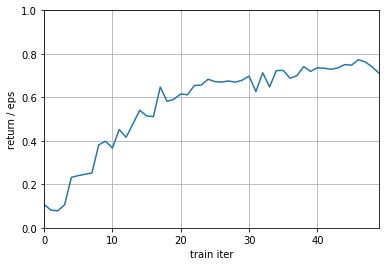

Total reward: 0.6399999999999999
Total length: 20


Total reward: 0.91
Total length: 5


Total reward: 0.874
Total length: 7


In [75]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

## 5. Testing on more complex environments (2 pts)

Now that we have seen that we can solve a very simple environment with vanilla policy gradients, let's try harder ones and see how the algorithm behaves!

We start with a **bigger gridworld**. This makes the problem *sparser*, i.e. the algorithm sees less rewards early on in training. 

In [76]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 50,         # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'MiniGrid-Empty-8x8-v0',  # we are using a tiny environment here for testing
)


env, rollouts, policy = instantiate(params)
rewards, success_rate = train(env, rollouts, policy, params)
print("Training completed!")

Training completed!


### Evaluation - bigger gridworld
Now again plot the final training curve as well as some policy rollouts.

**HINT**: The average episode reward should also reach ~0.5 after ~60 iterations. If you can't achieve this result try rerunning your training, randomness can play a big role in the beginning of training.

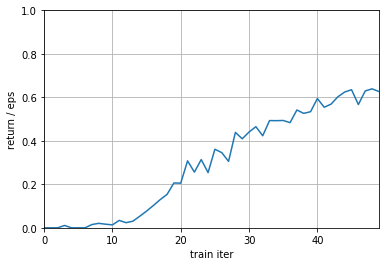

Total reward: 0.802
Total length: 11


Total reward: 0.73
Total length: 15


Total reward: 0.802
Total length: 11


In [77]:
# final reward + policy plotting for easier evaluation
plot_learning_curve(rewards, success_rate, params.num_updates)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

___
### Question (4 pts):

(1) Please compare the training curves for the two grids of different size. (2-line answer)

**Ans:** The returns of the larger grids increase slower in the first 10 to 20 iterations of training than the small grids, but after ~50 iterations it can reach a similar result to that of the small grids.
___
(2) Explain why the bigger maze tends to learn slower in the beginning of training. (2-line answer)

**Ans:** For the bigger maze, it is harder to get to the destination and earn rewards with a random policy in the beginning of training, so it learns and updates the policy slower.
___

## 6. Exploring the effect of Reward Design

Next we will test our algorithm on an even more challenging environment that includes obstacles in the form of walls and a bottleneck doorway the agent needs to pass through to reach the goal.

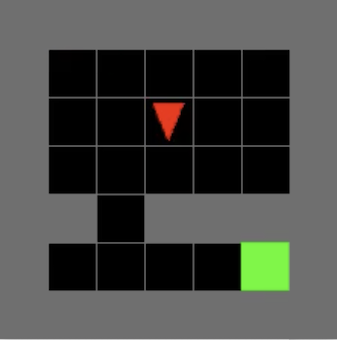

In this environment we will investigate the effect of different reward choices on the training dynamics and later how we can improve the vanilla REINFORCE algorithm we implemented above.

Rewards are central to RL as they provide guidance to the policy about the desired agent behavior. There are many different ways to specify rewards and each of them has their own trade-offs: from **easy to specify but hard to learn** all the way to **challenging to specify, but easy learning**. Let's explore the trade-offs we can make!


### Experimentation with multiple seeds (2 pts)

Before we move on to experimentation, an important aspect in reinforcement learning is to understand the impact of seed variability on experiments. Different seeds can affect training and exploration a lot, therefore it is common practice in RL research to run multiple seeds and plot the mean $\pm$ std of the results. This problem becomes more adverse on more complex environments, as randomness can have bigger influence on the results of training.

Therefore, for the following experiments, we will follow this practice and ask you to run **three random seeds** for the final submission results (Note that, in practice the more seeds the better).

You are free to run less seeds to debug your code, however we do **REQUIRE YOU TO SUBMIT RESULTS FOR ALL EXPERIMENTS BELOW WITH THREE RANDOM SEEDS**, otherwise we **WILL DEDUCT POINTS**!

In [11]:
n_seeds = 3

Try running the previous settings (bigger gridworld environment) with 3 seeds:

All training runs completed!


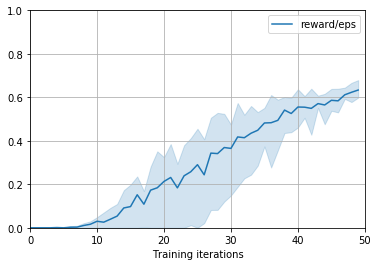

In [78]:
rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params)
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)

### Sparse Reward Environment (2 pts)
We start with the easiest to define version of rewards: sparse rewards. The idea is that we just define a very sparse signal, usually an indicator that some goal was achieved. This is in most cases pretty convenient, e.g. we can just detect whether our agent reached the goal and provide a positive reward if that was the case. 

The limitations of this formulation become quickly apparent when we think of more complex tasks. For example if an autonomous car would only receive a reward once it drove us to our goal location it would not get a lot of guidance on the way. As a rule of thumb: sparse rewards are easy to specify but usually hard to learn from.

We explore sparse rewards in our test environment by providing a reward of one when the agent reaches the target (minus a small penalty depending on how long it took the agent to get there) and zero reward otherwise. Run the training code on this new environment and see how the algorithm behaves. Since these environments are harder, we train it for longer (see *num_updates*).

**HINT**: If you want to explore the sparse reward environment or any of the following environments you can use the same `test_env_manual.py` script you used in the beginning to navigate using your keyboard. This will show you what rewards the agent receives in the different environments. Just make sure to uncomment the respective environment construction in the beginning of the `test_env_manual.py` file.

In [79]:
# Load the environment
from minigrid_utils import DeterministicCrossingEnv
import warnings

def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DeterministicCrossingEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [80]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_sparse',  # we are using a tiny environment here for testing
)

rewards_sparse, success_rates_sparse = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DeterministicCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_sparse.append(r); success_rates_sparse.append(sr)
print('All training runs completed!')

All training runs completed!


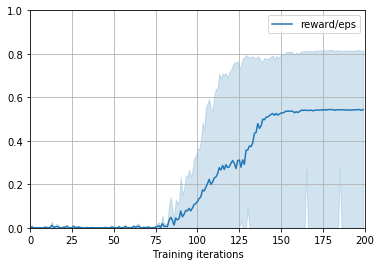

Total reward: 0.82
Total length: 10


Total reward: 0.82
Total length: 10


Total reward: 0.802
Total length: 11


In [81]:
plot_learning_curve(rewards_sparse, success_rates_sparse, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

#### "Densify" Reward

Sparse rewards are easy to specify but only provide very little feedback to the algorithm for what constitutes desirable behavior. As you have seen in the previous examples, this makes it very challenging to effectively learn a good policy. In practice, we therefore usually resort to constructing a more dense reward that gives the policy more "guidance" during learning. How to make the reward more dense is highly problem-dependent. 

Below we will test two custom environments that provide different options for a more dense reward on the obstacle-maze task and investigate whether this helps training the policy.

First we will overwrite the `gen_wrapped_env(...)` method used for logging such that it can handle the new environments.

In [82]:
from minigrid_utils import (DeterministicCrossingEnv, DetHardEuclidCrossingEnv,
                            DetHardSubgoalCrossingEnv)
import warnings

def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetSparseCrossingEnv()))
    if env_name is 'det_subgoal':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardSubgoalCrossingEnv()))
    elif env_name is 'det_euclid':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardEuclidCrossingEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

### Subgoal Reward (2 pts)

We will first try a hybrid solution between a sparse setup where the agent receives rewards only when the goal is reached and a truly dense setup where the agent receives reward in every step. Concretely, we will add one more **subgoal** to the environment to encourage the agent to reach the bottleneck state that passes through the wall. Upon reaching the subgoal the agent will receive a positive reward, encouraging it to reach the bottleneck more often. Laying out such a *"path of breadcrumbs"* is a standard practice in RL and we will explore whether our agent can benefit from it.

Execute the cells below to train the algorithm on the subgoal-based environment.

In [83]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_subgoal',  # we are using a tiny environment here for testing
)

rewards_subgoal, success_rates_subgoal = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DetHardSubgoalCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_subgoal.append(r); success_rates_subgoal.append(sr)
print('All training runs completed!')

All training runs completed!


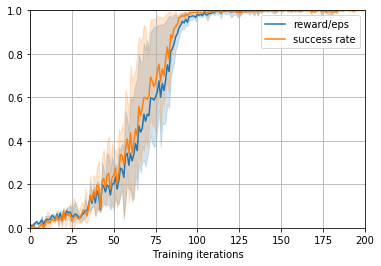

Total reward: 1.02
Total length: 10


Total reward: 1.02
Total length: 10


Total reward: 1.02
Total length: 10


In [84]:
plot_learning_curve(rewards_subgoal, success_rates_subgoal, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

### Dense Reward (distance-based) (2 pts)

While adding subgoals provided some guidance signal to the agent, we will try to further "densify" the reward formulation. Concretely, we will explore a rather straightforward way to define a dense reward: we will use the euclidean distance $d$ between the current agent position to the goal to define a reward. 

At this point one could be tempted to simply use the complement $1-d$ as reward such that maximizing it would lead the agent to minimize the distance to the goal. This is a good example for why specifying dense rewards is hard! If we were to choose this simple reward formulation the agent would actually be encouraged to move next to the goal,  but then **wait next to the goal** until right before the timeout of the episode is reached as terminating early is worse than receiving a long stream of high rewards while waiting next to the goal.

To prevent such "lazyness", we instead look at the differnce of the current distance to the goal and the previous step's distance. If this difference is negative, i.e. if we moved closer to the goal with the last action, we reward the agent. If we moved away from the goal we instead return a negative reward to the agent. If we distance does not change, i.e. if the agent stays in place, we do not provide any reward. In this way the agent is encouraged to choose actions that bring it closer to the goal while there is no benefit to waiting next to the goal (the discount factor <1 ensures that waiting is actually a bad choice).

Run the following cells to train an agent on the euclidean-distance-based dense reward environment.

In [85]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'det_euclid',  # we are using a tiny environment here for testing
)

rewards_dense, success_rates_dense = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=DetHardEuclidCrossingEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_dense.append(r); success_rates_dense.append(sr)
print('All training runs completed!')

All training runs completed!


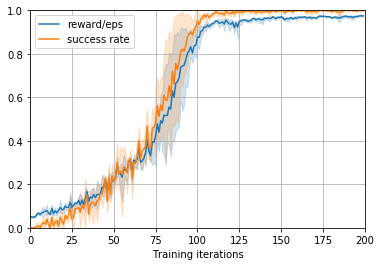

Total reward: 0.98
Total length: 10


Total reward: 0.98
Total length: 10


Total reward: 0.98
Total length: 10


In [86]:
plot_learning_curve(rewards_dense, success_rates_dense, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

### Optimal Dense Reward (4 pts)

In the previous example we saw that adding dense rewards can help speeding up training, however there were some degeneracies which discouraged the agent from learning the optimal policy. This process is typical when tackling a new task with RL: one tries sparse rewards and then keeps increasing the density of the reward until the agent is able to learn the desired behavior. Along the way the agent will discover various ways in which to exploit the different reward choices (remember the "lazy" behavior described above), requiring tedious changes to the reward design. This process, known as "reward engineering" is a big pain when developing RL solutions.

In the following we will sidestep this process. In our simple obstacle maze environment it is relatively straightforward to define a reward that is likely very close to "optimal". We will alter the dense reward from the previous section to use the **shortest-path distance** between the agent and the goal. We do this by computing the [manhattan distance](https://www.quora.com/What-is-Manhattan-Distance) while taking the walls into account.

In the following code, implement manhattan distance, and then run your custom environment below.

In [91]:
from minigrid_utils import DetHardOptRewardCrossingEnv

class CustomEnv(DetHardOptRewardCrossingEnv):
    def manhattan_distance(self, x, y):
        ############################## TODO: YOUR CODE BELOW ###############################
        ### Compute the manhattan distance between two coordinates x and y                ###
        ### x and y are 2D numpy arrays                                                  ###
        ####################################################################################
        distance = np.sum(np.abs(np.array(x)-np.array(y)), axis=0)
        ################################# END OF YOUR CODE #################################
        return distance
    
def gen_wrapped_env(env_name):
    if env_name is 'det_sparse':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetSparseCrossingEnv()))
    elif env_name is 'det_subgoal':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardSubgoalCrossingEnv()))
    elif env_name is 'det_euclid':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(DetHardEuclidCrossingEnv()))
    elif env_name is 'custom_env':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(CustomEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [98]:
# hyperparameters
policy_params = ParamDict(
    policy_class = Policy,    # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards_custom, success_rates_custom = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards_custom.append(r); success_rates_custom.append(sr)
print('All training runs completed!')

All training runs completed!


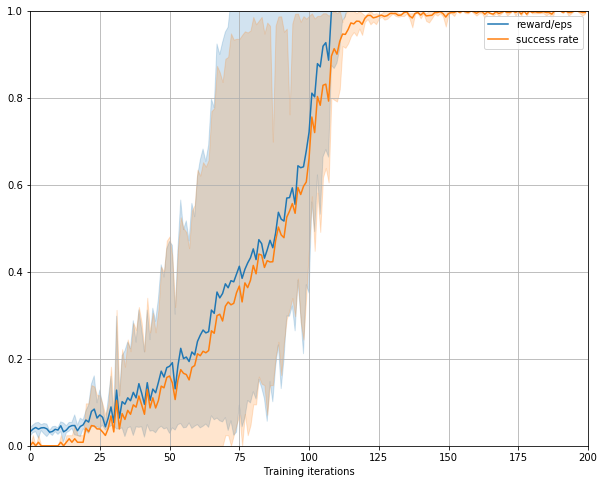

Total reward: 1.17
Total length: 10


Total reward: 1.17
Total length: 10


Total reward: 1.17
Total length: 10


In [99]:
plot_learning_curve(rewards_custom, success_rates_custom, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

### Compile Reward Design Results (1 pt)
In order to make comparison across reward design experiments easier, please run the following code block to make a combined code block.

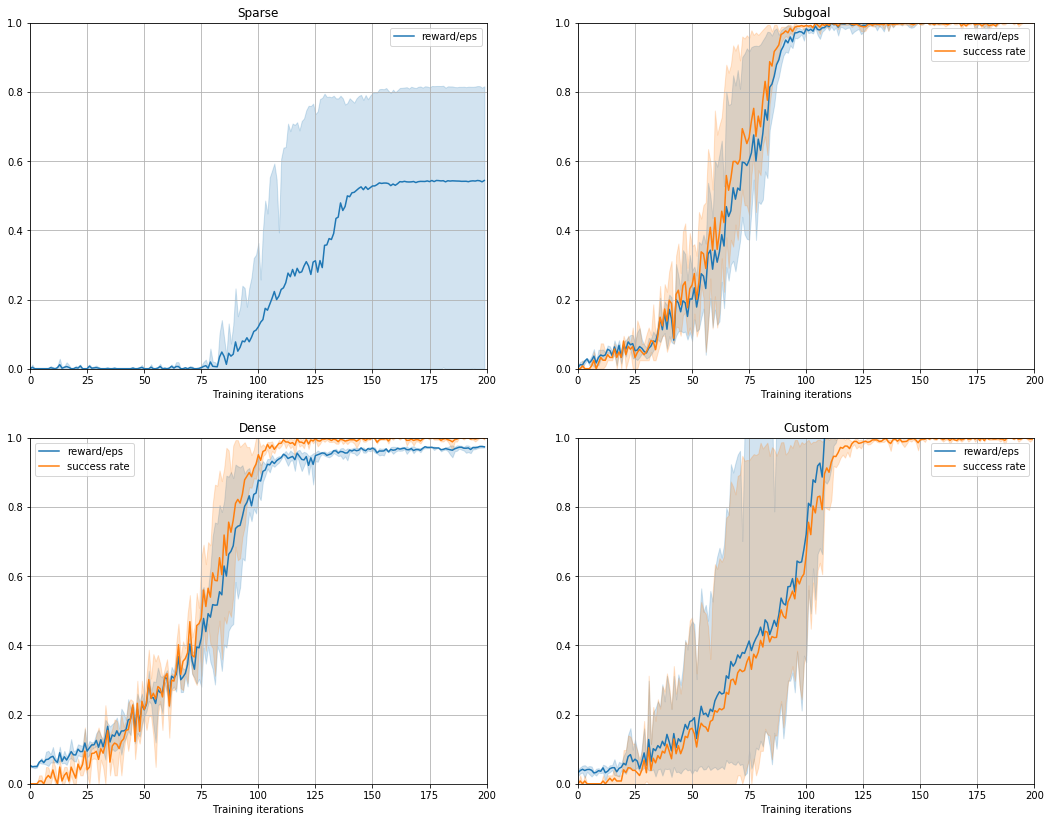

In [100]:
from utils import plot_grid_std_learning_curves
plots = {
'Sparse': (rewards_sparse, success_rates_sparse),
'Subgoal': (rewards_subgoal, success_rates_subgoal),
'Dense': (rewards_dense, success_rates_dense),
'Custom': (rewards_custom, success_rates_custom)}

plt.rcParams['figure.figsize'] = (18.0, 14.0) # set default size of plots
plot_grid_std_learning_curves(plots, params.num_updates)
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


___
### Questions (9 pts)
Give **two-line** answers to the following questions:

(1) Compare the performance of the different dense reward formulations. Which formulation is better and why do you think so? (3 pts)

**Ans:** The fisrt distance-based dense reward is better in this case based on my training results. For the two dense rewards, the average performances are similar with ~1.0 rewards after ~100 iterations. But the first distance-based dense reward has a smaller variance, so the performances with different seeds are more stable. While for the custom one, for some seeds it may have slower learning speed.
***

(2) What are some real world applications where it is easy to design dense rewards, and what are some where it is not possible? (3 pts)

**Ans:** For cases that the agents always know the finishing states and can measure the 'distance' between current state and ending states, such as navigating robots to a target destination, dense rewards are easier to design. For cases that the agents only knows success/fail at the very end and needs multiple middle stages, such as cooking a dish or making clothes, are hard to design dense reward.
***

(3) Based on the insights gain from experiments above, what is a good strategy to adopt in scenarios where good dense reward is not available? Why do you think so? (3 pts)

**Ans:** We can seperate the complex task into steps as small as possible and set up subgoal rewards for finishing these steps. The results of using subgoal reward in the above grid case are quite similar to those of using dense reward, indicating that subgoal reward is useful to reduce the random search space of the agents and make agents get returns faster and therefore learn faster.

***

## 7. Add a Baseline Network (10 pts)

Since REINFORCE relies on **sampling**-based gradient estimates to update the policy, the gradients can be very noisy, which can make the training unstable and slow.
There are many ways which attempt to reduce the variance in learning, and one such way is to use a **baseline**.

The key idea of a baseline is that if we add or subtract a term $b(s_t)$ which is independent of action to the estimated returns $V_t$, then the expected value still remains the same:

$$ \nabla J(\theta) = \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; V_t(s) \big] 
= \mathbb{E}_{\pi}\big[ \nabla_{\theta} \log \pi_{\theta}(a, s) \; [V_t(s) - b_t(s)] \big] $$

Hence, this keeps the gradient estimates unbiased (that is close to real gradients), and can help in reducing the variance if it is able to reduce the magnitude of gradients. Reduced variance can potentially lead to more stable training.

A good baseline to use is the value function of a state $b_t(s) = v_t(s)$, which can be trained along with the policy. The value function acts like a **critic** to the **actor** (policy network), where the critic's objective is to estimate correct expected returns $V_t(s)$ and actor's objective is the policy gradient augmented by critic's predictions.

The term $V_t(s) - v_t(s)$ is called the advantage, and it measures how well the policy is expected to do (estimated by expected rewards) as compared to the average value of a state (estimated by value function).

In [36]:
class CriticNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super().__init__()

        ############################## TODO: YOUR CODE BELOW ###############################
        ### 1. Build the Actor network as a torch.nn.Sequential module                   ###
        ###    with the following layers:                                                ###
        ###        (1) a Linear layer mapping from input dimension to hidden dimension   ###
        ###        (2) a Tanh non-linearity                                              ###
        ###        (3) a Linear layer mapping from hidden dimension to hidden dimension  ###
        ###        (4) a Tanh non-linearity                                              ###
        ###        (5) a Linear layer mapping from hidden dimension to appropriate       ###
        ###            dimension                                                         ###
        ### HINT: We do not need an activation on the output, because the actor is       ###
        ###       predicting a value, which can be any real number                       ###
        ####################################################################################
        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        ################################# END OF YOUR CODE #################################

    def forward(self, state):
        x = self.fc(state)
        return x


class ACPolicy(Policy):
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs,
                 entropy_coef=0.001, critic_coef=0.5):
        super().__init__(num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs, entropy_coef)

        self.critic = CriticNetwork(num_inputs, hidden_dim)
        
        ############################## TODO: YOUR CODE BELOW ###############################
        ### Create a common optimizer for actor and critic with the given learning rate  ###
        ### (requires 1-line of code)                                                    ###
        ####################################################################################
        self.optimizer = optim.Adam(list(self.actor.parameters())+list(self.critic.parameters()),
                                    lr=learning_rate)
        ################################# END OF YOUR CODE #################################

        self.critic_coef = critic_coef
        
    def update(self, rollouts):    
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                value_batch = self.critic(obs_batch)
                advantage = returns_batch - value_batch.detach()

                ############################## TODO: YOUR CODE BELOW ###############################
                ### 1. Compute the mean loss for the policy update using action log-             ###
                ###     probabilities and advantages.                                            ###
                ### 2. Compute the mean entropy for the policy update                            ###
                ### 3. Compute the critic loss as MSE loss between estimated value and expected  ###
                ###     returns.                                                                 ###
                ###    *HINT*: Carefully select the signs of each of the losses .                ###
                ####################################################################################
                policy_loss = -torch.mean(torch.mul(log_probs_batch, advantage), 0)
                entropy_loss = -torch.mean(entropy_batch, 0)
                critic_loss = torch.mean(torch.pow(returns_batch-value_batch, 2), 0)
                ################################# END OF YOUR CODE #################################
                
                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
    @property
    def num_params(self):
        return super().num_params + count_model_params(self.critic)

In [39]:
# hyperparameters
policy_params = ParamDict(
    policy_class = ACPolicy,  # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

All training runs completed!


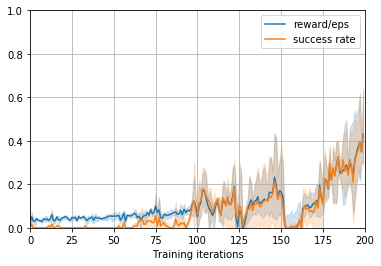

Total reward: 0.914
Total length: 27


Total reward: 1.1340000000000001
Total length: 12


Total reward: 1.1520000000000001
Total length: 11


In [40]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

### Questions (4 pts)

(1) How does the actor critic algorithm perform as compared to vanilla policy gradients?

**Ans:** The actor critic algorithm performs more unstable during training and the final results are worse than vanilla policy gradients in 200 iterations for this case.
___

(2) Can we make reliable comparisons with these experiments and plots, and why do you think so?

**Ans:** No. Because randomness plays an important role in the training of actor critic algorithm, 3 seeds and 200 iterations may be not enough for getting a reliable performance of actor critic.
___


## 8. Proximal Policy Optimization (PPO) (8 pts)

[PPO](https://arxiv.org/abs/1707.06347) is an actor-critic algorithm which constrains the gradient updates to a policy by modifying the training objective with a clipped surrogate objective. This essentially results in a more stable optimization procedure, and hence leads to better sample efficiency and fast computation time, as compared to vanilla policy gradient methods. It is very easy to implement, and here you are supposed to modify the update function of Actor Critic Policy to incorporate these surrogate losses.

$$ ratio = \frac{\pi^{new}(a)}{\pi^{old}(a)} = e^{log \pi^{new}(a) - log \pi^{old}(a)}  $$
$$ \mathcal{L}_{surrogate1} = ratio * Advantage $$
$$ \mathcal{L}_{surrogate2} = clip (ratio, 1 - c, 1 + c) * Advantage $$
$$ \mathcal{L}_{policy} = - min(\mathcal{L}_{surrogate1}, \mathcal{L}_{surrogate2})$$



In [46]:
class PPO(ACPolicy):       
    def update(self, rollouts): 
        self.clip_param = 0.2
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size, get_old_log_probs=True)
            
            for sample in data:
                actions_batch, returns_batch, obs_batch, old_log_probs_batch = sample
                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)
                
                value_batch = self.critic(obs_batch)
                
                advantage = returns_batch - value_batch.detach()
                old_log_probs_batch = old_log_probs_batch.detach()

                ############################## TODO: YOUR CODE BELOW ###############################
                ### Compute the following terms by following the equations given above           ###
                ### Useful functions: torch.exp(...), torch.clamp(...)
                ### Note: self.clip_param is the c in the above equations                        ###
                ### Compute the following terms by following the equations given above           ###
                ####################################################################################
                ratio = torch.exp(log_probs_batch-old_log_probs_batch)
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1-self.clip_param, 1+self.clip_param) * advantage

                policy_loss = torch.mean(-torch.min(surr1, surr2))
                entropy_loss = -torch.mean(entropy_batch, 0)
                critic_loss = torch.mean(torch.pow(returns_batch-value_batch, 2), 0)
                ################################# END OF YOUR CODE #################################

                loss = policy_loss + \
                        self.critic_coef * critic_loss + \
                        self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()

In [47]:
# hyperparameters
policy_params = ParamDict(
    policy_class = PPO,  # Policy class to use (replaced later)
    hidden_dim = 32,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1024,        # batch size for policy update
    policy_epochs = 4,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 2050,      # number of collected rollout steps per policy update
    num_updates = 200,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 10,      # interval for logging graphs and policy rollouts
    env_name = 'custom_env',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=CustomEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

All training runs completed!


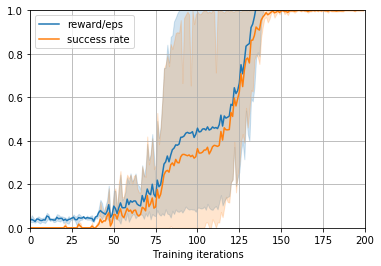

Total reward: 1.17
Total length: 10


Total reward: 1.17
Total length: 10


Total reward: 1.17
Total length: 10


In [48]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)

### Questions (2 pts)

How does PPO compare to the actor-critic method (i.e. with baseline and without surrogate objective) in your experimental results? (2-line answer)

**Ans:** PPO performs much better than actor-critic method by providing a significantly better final result after ~200 itrations, the learning speed is faster and the learning process is more stable.
___

### Questions (3 pts)

Following all the experiments in the assignment, what do you think are the bigger problems in Reinforcement Learning? e.g. exploration, sparsity, etc. Describe any 3 such problems, and how exactly you infer that from your experiments (3-line answer)

**Ans:** 1. Sparsity: if we only have sparse rewards as the first experiment we did, its hard for the agents to learn and the results may be not good enough; 2. Reward Design: In this case we can design good dense rewards but for more real applications, dense rewards are hard to sedign but extremely important; 3. Randomness: randomness plays an important role in RL, as we can get very different training results for different seeds.
___

## Solve your own environment! (5 pts + 4 pts)

Until this point, we only dealt with static environments, where the walls do not change across episodes. For this last open-ended task, we want you to solve a more complex task of your choice - Lava or Wall.

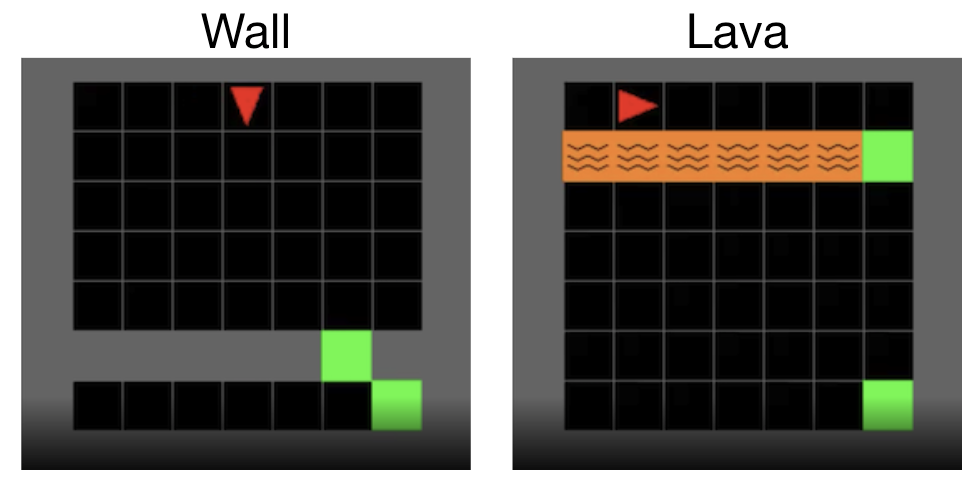

If the agent walks into lava, it dies and the game ends, whereas the wall environment is a bigger and randomized version of the task you have been solving.

We ask you to solve a subgoal-based version of this environment, and you are free to modify any code below this block (except environment code we have given) - with your choice of algorithm and hyperparameters. Please implement the full pipeline as in examples above (taking care of env_name and environment class).

**5 pts**: For successfully running the training and plotting pipeline (over >=3 seeds).

**4 pts**: Achieving non-trivial accuracy - Graded relative to other students who picked your task.

In [50]:
from minigrid_utils import LavaEnv, WallEnv
    
def gen_wrapped_env(env_name):
    if env_name is 'lava':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(LavaEnv()))
    if env_name is 'wall':
        warnings.filterwarnings("ignore")   # suppress warning when plotting
        return wrap_env(FlatObsWrapper(WallEnv()))
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

In [67]:
# TODO Implement and plot. We want to see the plot of your agent's performance on the environment of your choice.
# hyperparameters
policy_params = ParamDict(
    policy_class = PPO,  # Policy class to use (replaced later)
    hidden_dim = 640,          # dimension of the hidden state in actor network
    learning_rate = 1e-3,     # learning rate of policy update
    batch_size = 1536,        # batch size for policy update
    policy_epochs = 40,        # number of epochs per policy update
    entropy_coef = 0.001,     # hyperparameter to vary the contribution of entropy loss
    critic_coef = 0.5         # Coefficient of critic loss when weighted against actor loss
)
params = ParamDict(
    policy_params = policy_params,
    rollout_size = 3000,      # number of collected rollout steps per policy update
    num_updates = 600,        # number of training policy iterations
    discount = 0.99,          # discount factor
    plotting_iters = 50,      # interval for logging graphs and policy rollouts
    env_name = 'wall',  # we are using a tiny environment here for testing
)

rewards, success_rates = [], []
for i in range(n_seeds):
    print("Start training run {}!".format(i))
    env, rollouts, policy = instantiate(params, nonwrapped_env=WallEnv())
    r, sr = train(env, rollouts, policy, params, seed=i)
    rewards.append(r); success_rates.append(sr)
print('All training runs completed!')

All training runs completed!


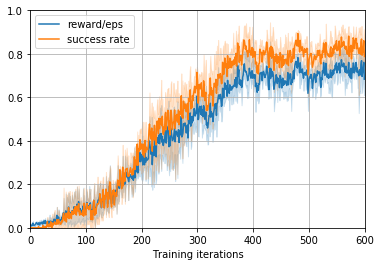

Total reward: 0.9119999999999999
Total length: 16


Total reward: 0.9299999999999999
Total length: 15


Total reward: 0.948
Total length: 14


In [68]:
plot_learning_curve(rewards, success_rates, params.num_updates, plot_std=True)
for _ in range(3):
    log_policy_rollout(policy, params.env_name, pytorch_policy=True)